- Install Anaconda
- Install Cuda

# Install Anaconda:


# Install Cuda:
sudo apt-get update
sudo apt-get install cuda-toolkit
sudo apt-get install nvidia-gds
sudo reboot

# Installing Hugging Face

python -m envName .env
source .envName/bin/activate

or,

conda create -n envName python=\<python_version\>
conda activate envName

- Install PyTorch

pip install transformers

In [ ]:
# Download models:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("bigscience/T0_3B")
model = AutoModelForSeq2SeqLM.from_pretrained("bigscience/T0_3B")

# Save models:
tokenizer.save_pretrained("./your/path/bigscience_t0")
model.save_pretrained("./your/path/bigscience_t0")

# Load models
tokenizer = AutoTokenizer.from_pretrained("./your/path/bigscience_t0")
model = AutoModel.from_pretrained("./your/path/bigscience_t0")

# VQA

## VisualBERT: not working

In [ ]:
# Assumption: *get_visual_embeddings(image)* gets the visual embeddings of the image in the batch.
from transformers import AutoTokenizer, VisualBertForMultipleChoice
import torch

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = VisualBertForMultipleChoice.from_pretrained("uclanlp/visualbert-vcr")

prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
choice0 = "It is eaten with a fork and a knife."
choice1 = "It is eaten while held in the hand."

visual_embeds = get_visual_embeddings(image)
# (batch_size, num_choices, visual_seq_length, visual_embedding_dim)
visual_embeds = visual_embeds.expand(1, 2, *visual_embeds.shape)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float)

labels = torch.tensor(0).unsqueeze(0)  # choice0 is correct (according to Wikipedia ;)), batch size 1

encoding = tokenizer([[prompt, prompt], [choice0, choice1]], return_tensors="pt", padding=True)
# batch size is 1
inputs_dict = {k: v.unsqueeze(0) for k, v in encoding.items()}
inputs_dict.update(
    {
        "visual_embeds": visual_embeds,
        "visual_attention_mask": visual_attention_mask,
        "visual_token_type_ids": visual_token_type_ids,
        "labels": labels,
    }
)
outputs = model(**inputs_dict)

loss = outputs.loss
logits = outputs.logits

In [ ]:
from transformers import AutoTokenizer, VisualBertForMultipleChoice
import torch

# Define your get_visual_embeddings function
def get_visual_embeddings(image):
    # Implementation of extracting visual embeddings from image
    # This function should return visual embeddings
    pass

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = VisualBertForMultipleChoice.from_pretrained("uclanlp/visualbert-vcr")

# Sample prompt and choices
prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
choice0 = "It is eaten with a fork and a knife."
choice1 = "It is eaten while held in the hand."

# Assuming you have the image for which you want to extract visual embeddings
image = None  # Replace None with your image

# Get visual embeddings from the image
visual_embeds = get_visual_embeddings(image)
# Assuming visual_embeds has the shape: (batch_size, visual_seq_length, visual_embedding_dim)

# Expand visual embeddings to match the batch size and number of choices
visual_embeds = visual_embeds.unsqueeze(0).expand(1, 2, *visual_embeds.shape)

# Create visual token type ids and attention mask
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float)

# Define labels
labels = torch.tensor(0).unsqueeze(0)  # choice0 is correct (according to Wikipedia ;)), batch size 1

# Tokenize prompt and choices
encoding = tokenizer([[prompt, prompt], [choice0, choice1]], return_tensors="pt", padding=True)

# Prepare inputs for the model
inputs_dict = {k: v.unsqueeze(0) for k, v in encoding.items()}
inputs_dict.update(
    {
        "visual_embeds": visual_embeds,
        "visual_attention_mask": visual_attention_mask,
        "visual_token_type_ids": visual_token_type_ids,
        "labels": labels,
    }
)

# Pass inputs to the model
outputs = model(**inputs_dict)

# Get loss and logits from the model outputs
loss = outputs.loss
logits = outputs.logits


## BLIP-2: https://huggingface.co/blog/blip-2

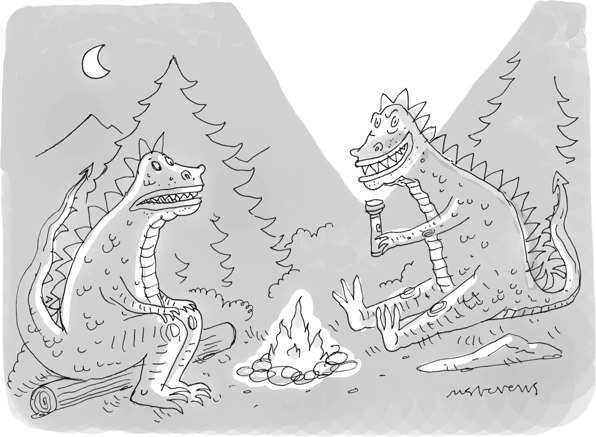

In [1]:
import requests
from PIL import Image

url = 'https://media.newyorker.com/cartoons/63dc6847be24a6a76d90eb99/master/w_1160,c_limit/230213_a26611_838.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')  
display(image.resize((596, 437)))


In [3]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16, low_cpu_mem_usage=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacity of 5.80 GiB of which 3.81 MiB is free. Including non-PyTorch memory, this process has 5.78 GiB memory in use. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 193.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
prompt = "Question: What is a dinosaur holding? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)


In [ ]:
context = [
   ("What is a dinosaur holding?", "a torch"),
   ("Where are they?", "In the woods.")
]
question = "What for?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)


In [ ]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)


## BLIP: https://huggingface.co/docs/transformers/main/model_doc/blip#blip
Salesforce/blip-vqa-capfilt-large

In [19]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

/home/lw-lab/Research/23-24_Automatic-Control-Lab/Multimodal Transformer/HuggingFace


In [20]:
directory = "/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/"
os.chdir(directory)


### Zero-shot

In [2]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

processor = BlipProcessor.from_pretrained("ybelkada/blip-vqa-capfilt-large")
model = BlipForQuestionAnswering.from_pretrained("ybelkada/blip-vqa-capfilt-large", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda")



/home/sunzid/anaconda3/envs/hugging-face/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

img_path = 'Images/7.jpg' # left
# img_path = '32271.jpg' # right
raw_image = Image.open(img_path).convert('RGB')

# question = "Is the humudifier in the left or right of the box?"
question = "Describe the image"
question
inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)

print(processor.decode(out[0], skip_special_tokens=True))



room is empty


/home/sunzid/anaconda3/envs/hugging-face/lib/python3.12/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


### Training

In [25]:
## Training

yes_image_folder = "/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/Yes" #Lab PC
question = "Is there humidifier vapor in this picture?"
label = "Yes"

# Get a list of all image files in the folder
image_files = [os.path.join(yes_image_folder, file) for file in os.listdir(yes_image_folder) if file.endswith((".jpg"))]

# Training loop
for image_file in image_files:
    image = Image.open(image_file)
    
    inputs = processor(images=image, text=question, return_tensors="pt")
    labels = processor(text=label, return_tensors="pt").input_ids

    inputs["labels"] = labels
    outputs = model(**inputs)
    loss = outputs.loss
    loss.backward()


no_image_folder = "/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/No"
question = "Is there humidifier vapor in this picture?"
label = "No"

# Get a list of all image files in the folder
image_files = [os.path.join(no_image_folder, file) for file in os.listdir(no_image_folder) if file.endswith((".jpg"))]

# Training loop
for image_file in image_files:
    image = Image.open(image_file)
    
    inputs = processor(images=image, text=question, return_tensors="pt")
    labels = processor(text=label, return_tensors="pt").input_ids

    inputs["labels"] = labels
    outputs = model(**inputs)
    loss = outputs.loss
    loss.backward()


In [26]:
# Inference
#Describe the image
yes_test_folder = "/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest"
# question = "You can only select either left or right. Which direction do you select in order to reach the humidifier?"
question = "Is there humidifier vapor in this picture?"

# Get a list of all image files in the folder
test_files = [os.path.join(yes_test_folder, file) for file in os.listdir(yes_test_folder) if file.endswith((".jpg"))]


# Inference
for yes_image_file in test_files:
    image = Image.open(yes_image_file)
    inputs = processor(images=image, text=question, return_tensors="pt")
    outputs = model.generate(**inputs)
    # print(processor.decode(outputs[0], skip_special_tokens=True))
    print(yes_image_file, "Actual: Yes; Model out: ", processor.decode(outputs[0], skip_special_tokens=True))


/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest/37502.jpg Actual: Yes; Model out:  yes
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest/33681.jpg Actual: Yes; Model out:  no
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest/33501.jpg Actual: Yes; Model out:  yes
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest/32704.jpg Actual: Yes; Model out:  yes
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest/34239.jpg Actual: Yes; Model out:  yes
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest/37245.jpg Actual: Yes; Model out:  yes
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest/33140.jpg Actual: Yes; Model out:  yes
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest/32930.jpg Actual: Yes; Model out:  yes
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest/35018.jpg Actual: Yes; Model out:  yes
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/YesTest/37367.jpg Actual: Yes; Model out:  yes
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/Yes

In [7]:
# Inference
 
no_test_folder = "/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/NoTest"
question = "Is there humidifier vapor in this picture?"

# Get a list of all image files in the folder
no_test_files = [os.path.join(no_test_folder, file) for file in os.listdir(no_test_folder) if file.endswith((".png"))]


# Inference
for no_image_file in no_test_files:
    image = Image.open(no_image_file)
    inputs = processor(images=image, text=question, return_tensors="pt")
    outputs = model.generate(**inputs)
    print(no_image_file, "Actual: No; Model out: ", processor.decode(outputs[0], skip_special_tokens=True))

/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/NoTest/6.png Actual: No; Model out:  no
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/NoTest/5.png Actual: No; Model out:  no
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/NoTest/7.png Actual: No; Model out:  no
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/NoTest/2.png Actual: No; Model out:  no
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/NoTest/1.png Actual: No; Model out:  no
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/NoTest/3.png Actual: No; Model out:  no
/home/lw-lab/Pictures/Turtlebot/HumidifierPlume/NoTest/4.png Actual: No; Model out:  no


### Cut image

In [ ]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

processor = BlipProcessor.from_pretrained("ybelkada/blip-vqa-capfilt-large")
model = BlipForQuestionAnswering.from_pretrained("ybelkada/blip-vqa-capfilt-large", torch_dtype=torch.float16).to("cuda")

In [29]:
import cv2

# Load the image
image = cv2.imread('Images/7.jpg')

# Get the dimensions of the image
height, width, _ = image.shape

# Calculate the dimensions for the nine equal parts
third_width = width // 3
third_height = height // 3

question = "Is there a humidifier in the image?"

caption = []

# Cut the image into nine equal parts
pieces = []
for i in range(3):
    for j in range(3):
        piece = image[i * third_height:(i + 1) * third_height, j * third_width:(j + 1) * third_width]
        pieces.append(piece)
        
        # caption
        inputs = processor(pieces, question, return_tensors="pt").to("cuda", torch.float16)
        
        out = model.generate(**inputs)

        caption.append(processor.decode(out[0], skip_special_tokens=True))

# Display or save the nine equal parts of the image
for idx, piece in enumerate(pieces):
    cv2.imshow(f'Piece {idx+1}', piece)
    # cv2.imwrite(f'piece_{idx+1}.jpg', piece)

cv2.waitKey(9999)
cv2.destroyAllWindows()


caption



ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

# Image classification

## Clip: https://huggingface.co/openai/clip-vit-large-patch14

In [ ]:
import cv2

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

image = cv2.imread('Images/7.jpg')

inputs = processor(text=["a photo of a humidifier", "a photo of a box"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

probs

### Cut image

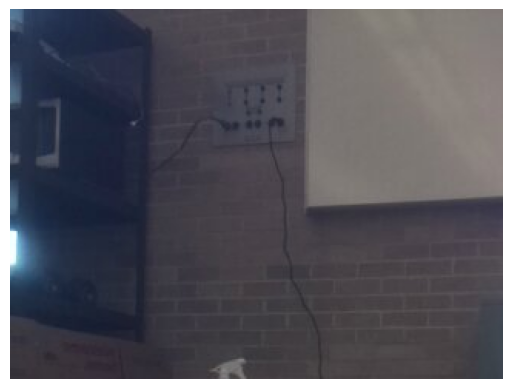

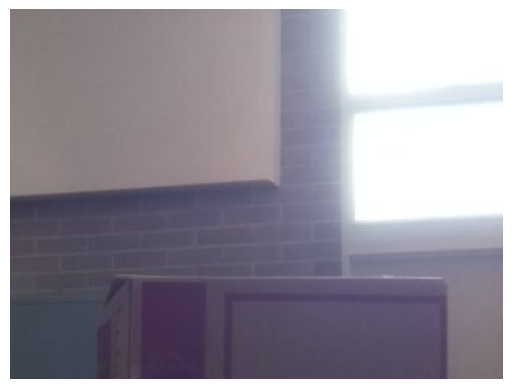

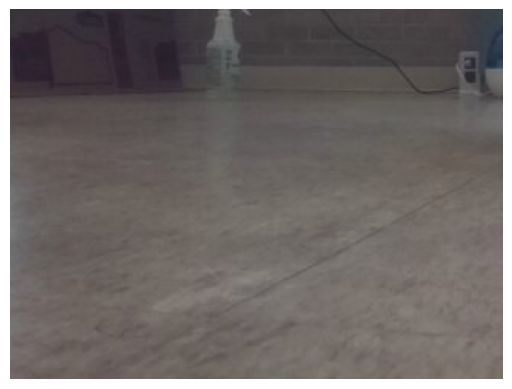

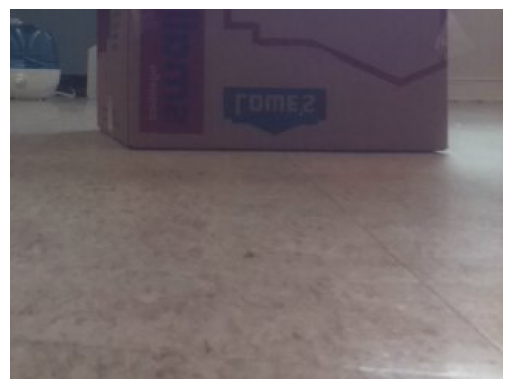

['power outlet', 'window', 'floor', 'box']


In [38]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
image = Image.open("Images/7.jpg")

width, height = image.size

m = 2  # Number of horizontal pieces
n = 2  # Number of vertical pieces

piece_width = width // n
piece_height = height // m

# Create a list to store the image pieces
pieces = []

# Loop through the rows and columns to extract image pieces
for row in range(m):
    for col in range(n):
        left = col * piece_width
        top = row * piece_height
        right = left + piece_width
        bottom = top + piece_height
        piece = image.crop((left, top, right, bottom))
        pieces.append(piece)


target_labels = ["humidifier", "spray", "box", "floor", "window", "wall", "power outlet"]
caption = []

for piece in pieces:
    inputs = processor(text=target_labels, images=piece, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    max_prob_index = probs.argmax()
    caption.append(target_labels[max_prob_index])
    
    plt.imshow(piece)
    plt.axis('off')
    plt.show(block=False)
    plt.pause(0)
    plt.close()

print(caption)



# Image segmentation

## SegFormer

In [4]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
list(logits.shape)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/home/sunzid/anaconda3/envs/hugging-face/lib/python3.12/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


[1, 150, 128, 128]

## ClipSeg

In [5]:
# model

from transformers import AutoProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests

clipSegProcessor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipSegModel = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")


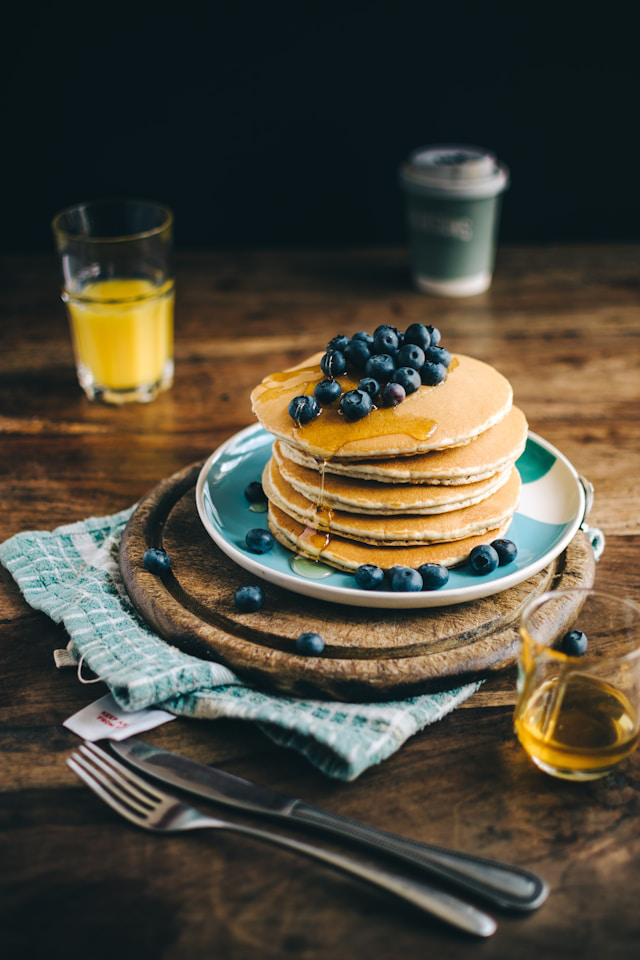

In [6]:
# image to segment
from PIL import Image
import requests

url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)
image

In [7]:
# Categories to segment

prompts = ["cutlery", "pancakes", "blueberries", "orange juice"]

In [8]:
# Process input
import torch

clipSegInputs = clipSegProcessor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  clipSegOutputs = clipSegModel(**clipSegInputs)
clipSegPreds = clipSegOutputs.logits.unsqueeze(1)


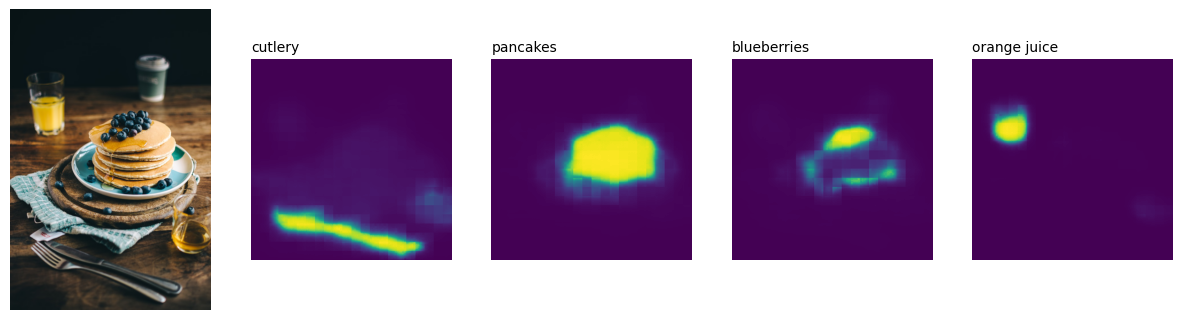

In [9]:
# visualize output
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(clipSegPreds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];


In [10]:
clipSegPreds

tensor([[[[ -9.0667,  -9.0309,  -9.1005,  ...,  -8.6963,  -8.6694,  -8.6553],
          [ -8.8863,  -8.6285,  -8.7702,  ...,  -8.5742,  -8.6038,  -8.5404],
          [ -8.4353,  -8.2756,  -8.5037,  ...,  -8.2710,  -8.3299,  -8.3215],
          ...,
          [ -7.0519,  -6.9689,  -6.9416,  ...,  -6.2335,  -6.3776,  -6.4667],
          [ -7.2497,  -7.2214,  -7.1477,  ...,  -6.4002,  -6.5871,  -6.6724],
          [ -7.5404,  -7.5925,  -7.4488,  ...,  -6.7739,  -6.8108,  -6.9504]]],


        [[[-10.0301,  -9.9645, -10.1595,  ...,  -9.4126,  -9.3725,  -9.3556],
          [ -9.8526,  -9.5759,  -9.7830,  ...,  -9.3321,  -9.3622,  -9.2823],
          [ -9.3869,  -9.2252,  -9.5680,  ...,  -9.0650,  -9.1767,  -9.1457],
          ...,
          [ -8.7815,  -8.6741,  -8.7022,  ...,  -7.9948,  -8.1859,  -8.3045],
          [ -8.8822,  -8.8385,  -8.8460,  ...,  -8.1018,  -8.3700,  -8.4941],
          [ -9.0617,  -9.1259,  -8.9746,  ...,  -8.4671,  -8.4894,  -8.7107]]],


        [[[ -9.7407,  -9.6

### On ACL data

In [ ]:
# model

from transformers import AutoProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests

clipSegProcessor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipSegModel = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")


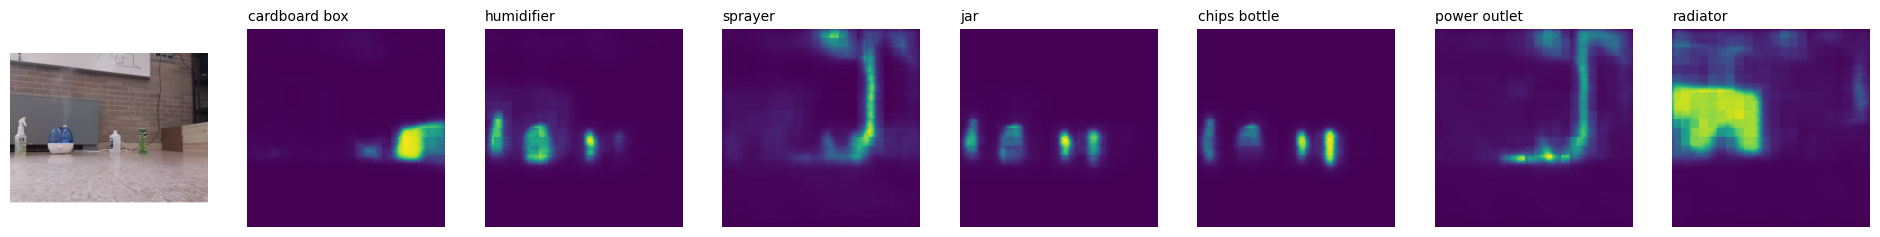

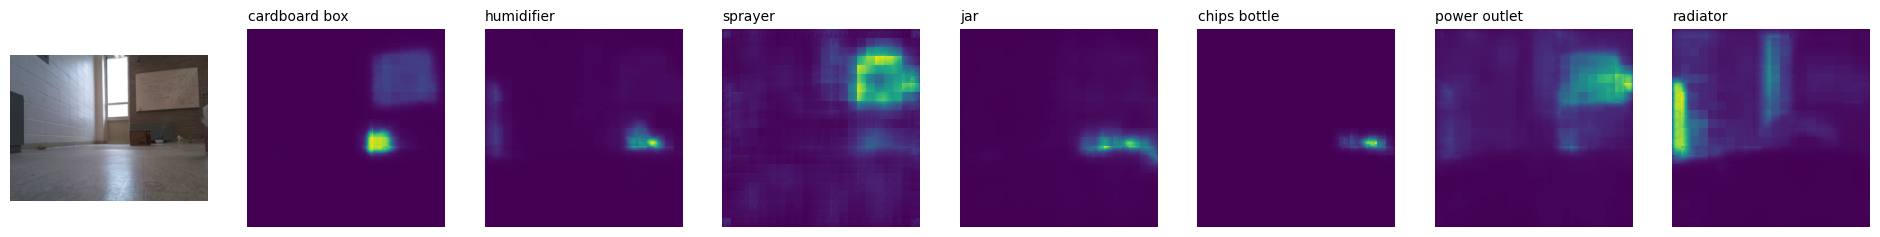

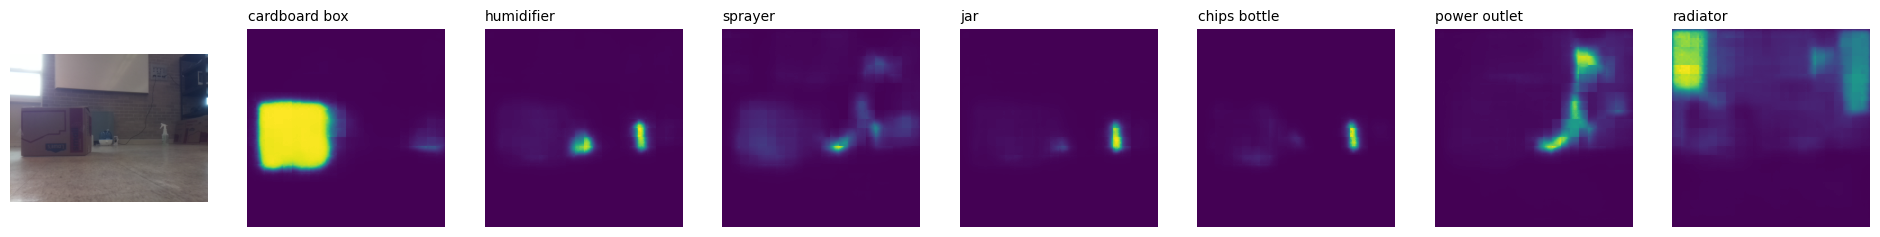

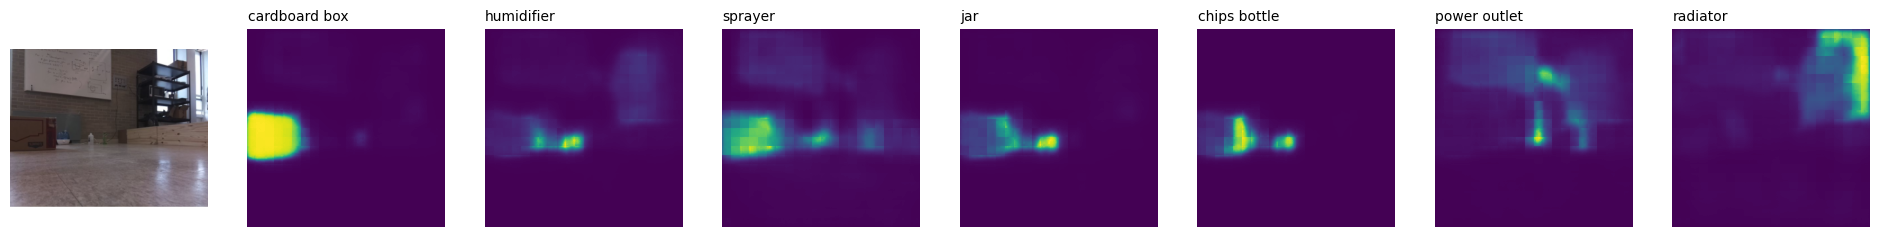

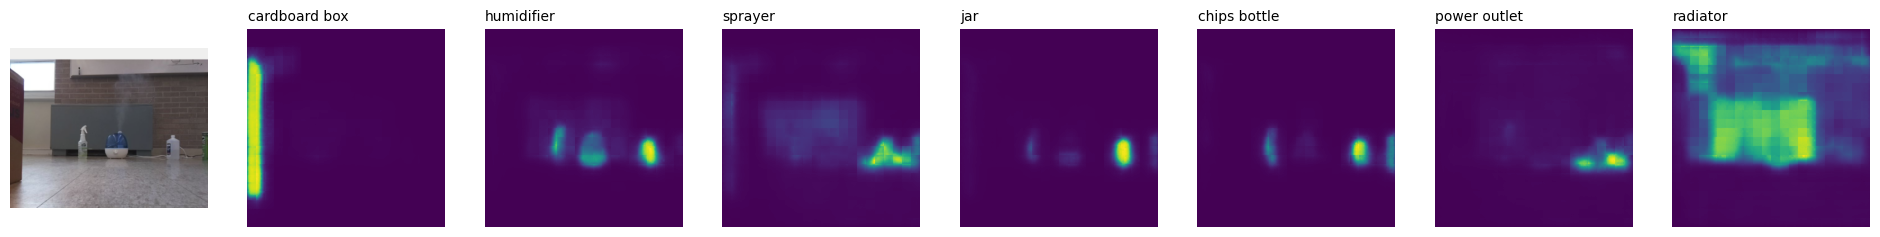

In [29]:
from PIL import Image
import os
import torch
import matplotlib.pyplot as plt

# Define the path to the folder containing images
folder_path = 'Images/Test'

# Get a list of all files in the folder
image_files = os.listdir(folder_path)

# Categories to segment
# prompts = ["floor", "wall", "window", "cardboard box", "humidifier", "bottle", "whiteboard", "shelf", "power outlet", "radiator", "wood board", "vapor"]
prompts = ["cardboard box", "humidifier", "sprayer", "jar", "chips bottle", "power outlet", "radiator"]

# Process each image
for image_file in image_files:
    # Load image
    img_path = os.path.join(folder_path, image_file)
    test_image = Image.open(img_path).convert('RGB')
    
    # Process input
    clipSegInputs = clipSegProcessor(text=prompts, images=[test_image] * len(prompts), padding="max_length", return_tensors="pt")
    
    # Predict
    with torch.no_grad():
        clipSegOutputs = clipSegModel(**clipSegInputs)
    clipSegPreds = clipSegOutputs.logits.unsqueeze(1)
    
    # Visualize output
    _, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
    [a.axis('off') for a in ax.flatten()]
    ax[0].imshow(test_image)
    [ax[i+1].imshow(torch.sigmoid(clipSegPreds[i][0])) for i in range(len(prompts))]
    [ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)]
    plt.show()


In [22]:
clipSegPreds

tensor([[[[-7.6790, -7.6549, -7.5433,  ..., -6.3085, -6.3531, -6.4211],
          [-7.5213, -7.2815, -7.2985,  ..., -6.1784, -6.2603, -6.2888],
          [-7.1599, -6.9641, -7.0356,  ..., -5.9472, -5.9903, -6.0604],
          ...,
          [-8.1457, -8.0000, -8.0026,  ..., -7.8797, -8.1107, -8.2711],
          [-8.1925, -8.1548, -8.1195,  ..., -7.9721, -8.2566, -8.4197],
          [-8.3832, -8.4214, -8.2643,  ..., -8.2725, -8.3401, -8.5789]]],


        [[[-8.0964, -8.0697, -8.0113,  ..., -6.0517, -6.1022, -6.1815],
          [-7.9456, -7.6951, -7.7564,  ..., -5.9144, -5.9916, -6.0374],
          [-7.5765, -7.3983, -7.5137,  ..., -5.6719, -5.7267, -5.8056],
          ...,
          [-8.1317, -7.9913, -7.9958,  ..., -7.8861, -8.1088, -8.2641],
          [-8.1839, -8.1475, -8.1143,  ..., -7.9803, -8.2632, -8.4203],
          [-8.3746, -8.4151, -8.2599,  ..., -8.2929, -8.3535, -8.5834]]],


        [[[-7.8608, -7.8239, -7.6861,  ..., -7.4075, -7.4006, -7.4333],
          [-7.7078, -7.443

# Multiple Choice LLM

## BERT

In [1]:
from transformers import AutoTokenizer, BertForMultipleChoice
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForMultipleChoice.from_pretrained("bert-base-uncased")

prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
choice0 = "It is eaten with a fork and a knife."
choice1 = "It is eaten while held in the hand."
labels = torch.tensor(0).unsqueeze(0)  # choice0 is correct (according to Wikipedia ;)), batch size 1

encoding = tokenizer([prompt, prompt], [choice0, choice1], return_tensors="pt", padding=True)
outputs = model(**{k: v.unsqueeze(0) for k, v in encoding.items()}, labels=labels)  # batch size is 1

# the linear classifier still needs to be trained
loss = outputs.loss
logits = outputs.logits

/home/lw-lab/anaconda3/envs/huggingFace/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lw-lab/anaconda3/envs/huggingFace/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/lw-lab/anaconda3/envs/huggingFace/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/lw-lab/anaconda3/envs/huggingFace/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Plea

# Experiment

#### Text prompt

In [ ]:
## Blip question answering 1

import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering


processor = BlipProcessor.from_pretrained("ybelkada/blip-vqa-capfilt-large")
model = BlipForQuestionAnswering.from_pretrained("ybelkada/blip-vqa-capfilt-large", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda")


img_path = '7.jpg'  # Replace with the actual path to your image
raw_image = Image.open(img_path).convert('RGB')

question = "A the robot needs to navigate to the humidifier without hitting the box. In which direction should the robot move - right-ahead, left-ahead, right-back or left-back?"
inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

FileNotFoundError: [Errno 2] No such file or directory: '7.jpg'

#### Training and simple question

In [ ]:
## Blip question answering 1

from PIL import Image
import requests
from transformers import AutoProcessor, BlipForQuestionAnswering

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")


img_path = '6.png'
raw_image = Image.open(img_path).convert('RGB')

# training
text = "Is the box at left or right of the humidifier?"
label = "left"
inputs = processor(images=image, text=text, return_tensors="pt")
labels = processor(text=label, return_tensors="pt").input_ids

inputs["labels"] = labels
outputs = model(**inputs)
loss = outputs.loss
loss.backward()

# inference
text = "Is the box at left or right of the humidifier?"
inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model.generate(**inputs)
print(processor.decode(outputs[0], skip_special_tokens=True))

right


#### Training with action output

In [ ]:
## Blip multiple choice image label???

from PIL import Image
import requests
from transformers import AutoProcessor, BlipModel

model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

img_path = '7.jpg'  # Replace with the actual path to your image
image = Image.open(img_path).convert('RGB')

inputs = processor(
    text=["go right", "go left"], images=image, return_tensors="pt", padding=True
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

/home/sunzid/anaconda3/envs/hugging-face/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['text_model.encoder.layer.2.output.dense.bias', 'text_model.encoder.layer.4.intermediate.dense.weight', 'text_model.encoder.layer.4.crossattention.self.value.weight', 'text_model.encoder.layer.3.attention.self.query.bias', 'text_model.encoder.layer.10.intermediate.dense.weight', 'text_model.encoder.layer.6.attention.self.key.weight', 'text_model.encoder.layer.10.attention.self.query.bias', 'text_model.encoder.layer.7.attention.self.query.weight', 'text_model.encoder.layer.5.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.8.intermediate.dense.weight', 'text_model.encoder.layer.8.attention.output.LayerNorm.bias', 'text_model.encoder.layer.7.crossattention.self.query.weight', 'text_model.encoder.layer.11.attention.output.dense.bias', 'text_model.encoder.layer.7.intermediate.dense.bias', 'te